## Importing Packages

Let's start by importing the core packages **numpy** and **pandas**.

In [ ]:
import numpy as np
import pandas as pd

## Reading-In Holdings File

Next, we read in the hodlings file that we cleaned in a prior notebook.

In [ ]:
df_holdings = pd.read_csv("../data/etf_holdings_clean.csv")
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000


## Adding `D2X`, `UPX`, `Moneyness`, `RF`, `DIV` Columns to `df_holdings`

At this point we can add a variety of columns, mostly from the data files that were provided for the assignment.  Notice that we use simple linear interpolation from **numpy** for the various curves.  In a more high stakes environment I might fit a parametric curve to the data to avoid overfitting.

In [ ]:
# adding D2X
from bizdays import Calendar
cal = Calendar.load("PMC/NYSE")

def bizdays(row):
    from_date = row["Date"]
    to_date = row["MaturityDate"]
    return cal.bizdays(from_date, to_date)

df_holdings["D2X"] = df_holdings.apply(bizdays, axis=1)

# adding UPX
df_spy = pd.read_csv("../data/spy.csv")
df_spy.dropna(inplace=True)
df_holdings["UPX"] = df_spy.query("date == '7/12/2024'").reset_index()['spy'][0]

# adding Moneyness
df_holdings["Moneyness"] = df_holdings["StrikePrice"] / df_holdings["UPX"]

# adding RF
df_risk_free = pd.read_csv("../data/rates.csv")

def risk_free(row):
    d2x = row["D2X"]
    # using simple linear interpolation
    return np.interp(d2x, df_risk_free["D2X"], df_risk_free["Close"])

df_holdings["RF"] = df_holdings.apply(risk_free, axis=1) / 100

# adding DIV
df_dividend = pd.read_csv("../data/spx_dividend.csv")
df_dividend["Date"] = pd.to_datetime('2024-07-12')
df_dividend["DivExpirationDate"] = pd.to_datetime(df_dividend["DivExpirationDate"], format="mixed", dayfirst=True)

def bizdays(row):
    from_date = row["Date"]
    to_date = row["DivExpirationDate"]
    return cal.bizdays(from_date, to_date)

df_dividend["D2X"] = df_dividend.apply(bizdays, axis=1)

def dividend(row):
    d2x = row["D2X"]
    # using simple linear interpolation
    dividend = np.interp(d2x, df_dividend["D2X"], df_dividend["DivCurve"])
    # I wasn't sure how to handle negative dividend yields would affect, so I set them to zero 
    if dividend < 0:
        dividend = 0
    return dividend

df_holdings["Div"] = df_holdings.apply(dividend, axis=1)

# printing holdings dataframe
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557


## Adding `VolatilityImplied` Column Implied from Prices

Let's now calculated implied volatilities based on the market option prices.  In order to do this we use the **py_vollib** package which is great for Black-Scholes-Merton pricing calculations. We first have to convert the `implied_volatility()` function into a form that can be used in the **pandas** `DataFrame.apply()` method.

Note: for the deep ITM calls, the `implied_volatility()` function was throwing an error.  I think this is because there are tax/regulatory reasons why deep ITM calls have a price that deviated from theoretically sound values.  Thus, for `Moneyness < 0.1`, I simply set the implied volatility equal to `0.25`.

In [ ]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

def implied_vol(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    price = row["Price"]
    q = row["Div"]

    # getting errors for deep ITM calls, so set those to a fixed value
    if strike / upx < 0.1:
        vol = 0.25
    else:
        vol = implied_volatility(price, upx, strike, t2x, rf, q, cp)
    vol = np.round(vol, 4)
    return vol

df_holdings["VolatilityImplied"] = df_holdings.apply(implied_vol, axis=1)

df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilityImplied
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596,0.2500
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596,0.1177
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596,0.2063
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596,0.1675
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557,0.2500
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557,0.1340
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557,0.2347
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557,0.1777


## Adding `Delta`, `Vega`, `Theta`

Next, let's calculated the greeks of the individual options in `df_holdings` using the **py_vollib** package.  Notice that all the function need to be converted into a form that can be used in the `DataFrame.apply()` method.

In [ ]:
# Delta
from py_vollib.black_scholes_merton.greeks.analytical import delta
def bsm_delta(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]
    
    if t2x == 0:
        return(0)
    diff = delta(cp, upx, strike, t2x, rf, volatility, q)
    diff = np.round(diff, 3)
    return(diff)

df_holdings['Delta'] = df_holdings.apply(bsm_delta, axis=1)  * np.sign(df_holdings['Shares'])

# Vega
from py_vollib.black_scholes_merton.greeks.analytical import vega

def bsm_vega(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]

    if t2x == 0:
        return(0)
    vga = vega(cp, upx, strike, t2x, rf, volatility, q)
    vga = np.round(vga, 3)
    return(vga)

df_holdings['Vega'] = df_holdings.apply(bsm_vega, axis=1) * np.sign(df_holdings['Shares'])

# Theta
from py_vollib.black_scholes_merton.greeks.analytical import theta

def bsm_theta(row):
    # undefined for cash
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)

    # grabbing data from input row
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row["VolatilityImplied"]
    q = row["Div"]
    
    if t2x == 0:
        return(0)
    tht = theta(cp, upx, strike, t2x, rf, volatility, q)
    tht = np.round(tht, 3)
    return(tht)

df_holdings['Theta'] = df_holdings.apply(bsm_theta, axis=1) * np.sign(df_holdings['Shares'])



# printing df_holdings
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596,0.2500,0.996,0.000,0.009
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596,0.1177,-0.268,-1.556,0.052
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596,0.2063,0.103,-0.847,0.026
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596,0.1675,-0.218,1.393,-0.029
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557,0.2500,0.998,0.000,0.008
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557,0.1340,-0.734,-1.019,0.109
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557,0.2347,0.034,-0.236,0.022
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557,0.1777,-0.096,0.531,-0.034


## Portfolio Greeks & Statistics

Now, we can do a simple `DataFrame.groupby()` to calculated portfolio greeks, and other portfolio metrics.

In [ ]:
agg_funcs = {
    'Delta':[np.sum],
    'Vega':[np.sum],
    'Theta':[np.sum],
    'MarketValue':[np.sum],
    'SharesOutstanding':[np.mean],
    'UPX': [np.mean],
}


# df_holdings.groupby(by=['Account'])[['Delta', 'Vega', 'Theta']].sum().reset_index()
df_portfolio_statistics = df_holdings.groupby(by=['Account']).agg(agg_funcs).reset_index()
df_portfolio_statistics.columns = df_portfolio_statistics.columns.get_level_values(0)
df_portfolio_statistics['SharePrice'] = np.round(df_portfolio_statistics['MarketValue'] / df_portfolio_statistics['SharesOutstanding'], 2)
df_portfolio_statistics

,Account,Delta,Vega,Theta,MarketValue,SharesOutstanding,UPX,SharePrice
0,APRT,0.613,-1.010,0.058,1.170081e+08,3175000.0,559.99,36.85
1,APRW,0.398,-0.955,0.071,3.307489e+08,10479000.0,559.99,31.56
2,ARLU,0.794,0.922,0.003,2.369939e+07,900000.0,559.99,26.33
3,AUGT,0.124,-0.254,0.150,2.719247e+07,925000.0,559.99,29.40
4,AUGW,0.025,-0.071,0.107,6.861884e+07,2450000.0,559.99,28.01
5,DECT,0.230,-0.960,0.108,2.037522e+07,650000.0,559.99,31.35
6,DECW,0.121,-0.595,0.099,8.065295e+07,2700000.0,559.99,29.87
7,FEBT,0.358,-1.298,0.091,4.041835e+07,1250000.0,559.99,32.33
8,FEBW,0.195,-0.883,0.091,8.300715e+07,2775000.0,559.99,29.91
9,FLAO,0.475,-0.706,0.076,7.555112e+07,2875000.0,559.99,26.28


## Shock-Report for APRT

In [ ]:
#df_aprt = df_holdings.query("Account == 'APRT' & StrikePrice == 617.33").copy()
df_aprt = df_holdings.query("Account == 'APRT'").copy()
df_aprt

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilityImplied,Delta,Vega,Theta
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596,0.2500,0.996,0.000,0.009
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596,0.1177,-0.268,-1.556,0.052
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596,0.2063,0.103,-0.847,0.026
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596,0.1675,-0.218,1.393,-0.029
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from py_vollib.black_scholes_merton import black_scholes_merton

def bsm_px(row, vol_column):
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)
    
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    #volatility = row["Volatility"]
    volatility = row[vol_column]
    q = row["Div"]
    px = black_scholes_merton(cp, upx, strike, t2x, rf, volatility, q)
    px = np.round(px, 4)
    
    return(px)

In [ ]:
vol_shocks = [0] #np.linspace(-0.10, 0.10, 3)
underlying_shocks = np.linspace(-0.99, 1, 51)

In [ ]:
df_shock_report = pd.DataFrame()

for vs in vol_shocks:
    for us in underlying_shocks:
        df_aprt_shocked = df_aprt.copy()
        df_aprt_shocked["VolatilityImplied"] += vs
        df_aprt_shocked["UPX"] *= (1 + us)
        
        df_aprt_shocked['ShockedPrice'] = df_aprt_shocked.apply(bsm_px, vol_column="VolatilityImplied", axis=1)
        df_aprt_shocked['ShockedMarketValue'] = df_aprt_shocked["Shares"] * df_aprt_shocked["ShockedPrice"] * 100
        
        agg_funcs = {
            'ShockedMarketValue':[np.sum],
            'SharesOutstanding':[np.mean],
            'UPX': [np.mean],
        }
        
        df_portfolio_statistics = df_aprt_shocked.groupby(by=['Account']).agg(agg_funcs).reset_index()
        df_portfolio_statistics.columns = df_portfolio_statistics.columns.get_level_values(0)
        df_portfolio_statistics['SharePrice'] = np.round(df_portfolio_statistics['ShockedMarketValue'] / df_portfolio_statistics['SharesOutstanding'], 2)
        df_portfolio_statistics['ShockVol'] = vs
        df_portfolio_statistics['ShockUnderlying'] = us

        df_shock_report = pd.concat([df_shock_report, df_portfolio_statistics])
df_shock_report

,Account,ShockedMarketValue,SharesOutstanding,UPX,SharePrice,ShockVol,ShockUnderlying
0,APRT,1.113105e+07,3175000.0,5.599900,3.51,0,-0.9900
0,APRT,1.585364e+07,3175000.0,27.887502,4.99,0,-0.9502
0,APRT,2.057851e+07,3175000.0,50.175104,6.48,0,-0.9104
0,APRT,2.530338e+07,3175000.0,72.462706,7.97,0,-0.8706
0,APRT,3.002827e+07,3175000.0,94.750308,9.46,0,-0.8308
0,APRT,3.475314e+07,3175000.0,117.037910,10.95,0,-0.7910
0,APRT,3.947800e+07,3175000.0,139.325512,12.43,0,-0.7512
0,APRT,4.420287e+07,3175000.0,161.613114,13.92,0,-0.7114
0,APRT,4.892776e+07,3175000.0,183.900716,15.41,0,-0.6716
0,APRT,5.365261e+07,3175000.0,206.188318,16.90,0,-0.6318


In [ ]:
import seaborn as sns

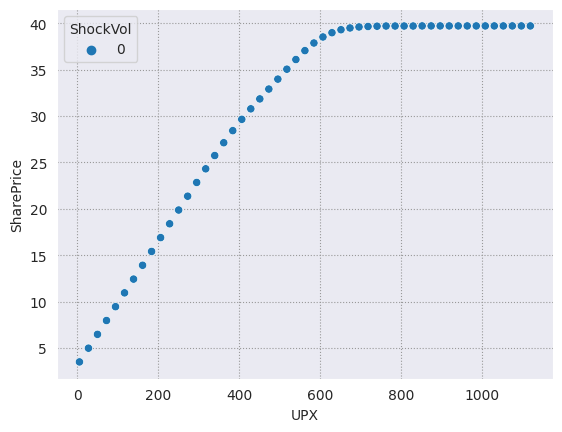

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
g = sns.scatterplot(data=df_shock_report, x='UPX', y='SharePrice', hue='ShockVol');
#g.set(xlim=(400, 600))